# Phase 6: Run Interactions

Documentation: 

In [1]:
import pandas as pd
from pathlib import Path
import igem

rpy2 ModuleSpec(name='rpy2', loader=<_frozen_importlib_external.SourceFileLoader object at 0x351f59f00>, origin='/Users/andrerico/Works/Projects/pbs_igem/.venv/lib/python3.10/site-packages/rpy2/__init__.py', submodule_search_locations=['/Users/andrerico/Works/Projects/pbs_igem/.venv/lib/python3.10/site-packages/rpy2'])


In [2]:
# define the path to the data folder
path = Path().resolve()
path_data = path / "data"

#### STEP 06_00: Prepare Identified Interaction Data (GE.db)

In [28]:
# Read Moldel (we need to clean interactions that is not in coluns list)
df_model = igem.epc.load.from_csv(str(path_data) + "/step_02_06_Models.csv") 
print(f"Start with: {len(df_model)} interactions")

Loaded 401,736 observations of 5 variables
Start with: 401736 interactions


Drop interactions that is not Exposures

--> These interactions pass the NHANES filter and we need to clean it now.

In [23]:
# list of no Exposure interactions
# description_list = [
#     "Homocysteine (umol/L)",
#     "Methylmalonic acid (umol/L)",
#     "Ferritin(ng/mL)",
#     "Glycohemoglobin (%)",
#     "Glucose, plasma (mg/dL)",
#     "C-peptide: SI(nmol/L)",
#     "C-reactive protein(mg/dL)",
#     "Bone alkaline phosphotase (ug/L)",
#     "Albumin, urine (ug/mL)",
#     "Albumin, urine (mg/L) SI",
#     "Lymphocyte percent (%)",
#     "Monocyte percent (%)",
#     "Segmented neutrophils percent (%)",
#     "Eosinophils percent (%)",
#     "Basophils percent (%)",
#     "Lymphocyte number",
#     "Monocyte number",
#     "Segmented neutrophils number",
#     "Eosinophils number",
#     "Red blood cell count (million cells/uL)",
#     "Hemoglobin (g/dL)",
#     "Hematocrit (%)",
#     "Mean cell volume (fL)",
#     "Mean cell hemoglobin (pg)",
#     "Red cell distribution width (%)",
#     "Platelet count SI (1000 cells/uL)",
#     "Mean platelet volume (fL)",
#     "Protoporphyrin(ug/dL RBC)",
#     "Albumin (g/dL)",
#     "Alanine aminotransferase ALT (U/L)",
#     "Aspartate aminotransferase AST (U/L)",
#     "Alkaline phosphotase (U/L)",
#     "Blood urea nitrogen (mg/dL)",
#     "Total calcium (mg/dL)",
#     "Bicarbonate (mmol/L)",
#     "Gamma glutamyl transferase (U/L)",
#     "Iron, refigerated (ug/dL)",
#     "Lactate dehydrogenase LDH (U/L)",
#     "Phosphorus (mg/dL)",
#     "Total bilirubin (mg/dL)",
#     "Total protein (g/dL)",
#     "Uric acid (mg/dL)",
#     "1/Creatinine (mg/dL)",
#     "Sodium (mmol/L)",
#     "Chloride (mmol/L)",
#     "Osmolality (mmol/Kg)",
#     "Globulin (g/dL)",
#     "TIBC, Frozen Serum (ug/dL)",
#     "Transferrin saturation (%)",
#     "Creatinine, urine (mg/dL)",
#     "Creatinine (mg/dL)",
#     "Basophils number",
#     "Iron, Frozen Serum (ug/dL)",
# ]
description_list = ['LBXSTB', 'LBDSTBLC', 'LBDTIB', 'LBXIRN', 'LBXSIR', 'URXUCR2', 'URDUCR2S', 'LBXSCR', 'URXUCR',
                    'URDUCRLC', 'LB2GLU', 'LBXSGL', 'LB2SGL', 'GTDSCMMN', 'LBXSGL', 'LBXSCA', 'LB2SCA', 'LB2SUA', 'LBXSUA', 'LBXSPH', 'LBXSBU', ]

print(f"Remove {len(description_list)} interactions")

Remove 21 interactions


In [24]:
# Function to verify if the description contains any of the description_list
def contains_any(description, description_list):
    return any(desc in description for desc in description_list)

In [31]:
# Dataframe filtered
df_model_filtered = df_model[
    ~df_model['field_name_1'].apply(lambda x: contains_any(x, description_list)) &
    ~df_model['field_name_2'].apply(lambda x: contains_any(x, description_list))
]

num_dropped = len(df_model) - len(df_model_filtered)
percentage_dropped = (num_dropped / len(df_model)) * 100
print(f'Dropped {num_dropped} ({percentage_dropped:.2f}%) interactions')


Dropped 19123 (4.76%) interactions


In [4]:
# Keep only interactions terms
df_model = igem.epc.modify.colfilter(
    df_model,
    only=['field_name_1', 'field_name_2']
    )
df_model.reset_index(drop=True, inplace=True)  

# Order terms
df_model['Ordered_Term1'] = df_model.apply(lambda row: min(row['field_name_1'], row['field_name_2']), axis=1)
df_model['Ordered_Term2'] = df_model.apply(lambda row: max(row['field_name_1'], row['field_name_2']), axis=1)

# Remove duplicates relationship terms
df_model = df_model.drop_duplicates(subset=['Ordered_Term1', 'Ordered_Term2']).copy()
df_model.drop(columns=['Ordered_Term1', 'Ordered_Term2'], inplace=True)

df_model.rename(columns={'field_name_1': 'Term1', 'field_name_2': 'Term2'}, inplace=True)

Running colfilter
--------------------------------------------------------------------------------
Keeping 2 of 5 variables:
	0 of 0 binary variables
	0 of 0 categorical variables
	0 of 0 continuous variables
	2 of 5 unknown variables


#### STEP 06_01: Process Interactions

In [5]:
# Function to check if columns exist in DataFrame
def columns_exist(df, cols):
        return all(col in df.columns for col in cols)

In [11]:
# Define the groups
list_covariates = ['RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'BMXBMI']
list_outcomes = ['LBDLDL_N', 'LBXTC_N', 'LBXSTR', 'LBDHDL', 'LBXHDD', 'LBDHDD']

# Define columns output regression list
ls_output = ["Outcome",
    "Term1",
    "Term2",
    "Converged",
    "pvalue",
    "N",
    "Red_Var1_beta",
    "Red_Var1_SE",
    "Red_Var1_Pval",
    "Red_Var2_beta",
    "Red_Var2_SE",
    "Red_Var2_Pval",
    "Full_Var1_Var2_beta",
    "Full_Var1_Var2_SE",
    "Full_Var1_Var2_Pval",
    "Full_Var1_beta",
    "Full_Var1_SE",
    "Full_Var1_Pval",
    "Full_Var2_beta",
    "Full_Var2_SE",
    "Full_Var2_Pval",
    "Log",
    ]

# Interactions drop list
list_interactions_drop = [
    ['LBXIRN', 'LBXSIR'],
    ]

In [7]:
# Function to check if interaction need to be drop
def should_drop_interaction(term1, term2):
    term_pair = {term1, term2}
    for interaction in list_interactions_drop:
        if term_pair == set(interaction):
            return True
    return False

In [8]:
# Interaction Regression Function
def run_interactions(df_models, df_data, outcome):
        
    list_results = []  

    for i_mappair in df_models.index:
        # get Exposomes
        e1 = df_models["Term1"][i_mappair]
        e2 = df_models["Term2"][i_mappair]

        # Check if the interaction is in the drop list
        if should_drop_interaction(e1, e2):
            print(f"Skipped (interaction to drop): {e1} and {e2}")
            continue

        # Check if columns exist in the DataFrame
        if columns_exist(df_data, [e1, e2]):
            # create a DataFrame with the columns of interest
            v_list = list_covariates + [outcome, e1, e2]
            df_exe = df_data.loc[:, v_list]
            print(f"Processed with: {e1} and {e2}")
        else:
            print(f"Skipped: {e1} and/or {e2} not found")
            continue

        # Drop Constants Columns
        non_constant_columns = df_exe.columns[df_exe.nunique() > 1]
        df_exe = df_exe[non_constant_columns]

        if not columns_exist(df_exe, v_list):
            continue
        if e1 == e2:
            continue

        # Run the interaction study
        Interation_Study = igem.epc.analyze.interaction_study(
            data=df_exe,
            outcomes=outcome,
            interactions=[(e1, e2)],
            covariates=list_covariates,
            report_betas=True,
            min_n=200,
        )

        # Keep the results values
        list_results.append(
            [
                Interation_Study.LRT_pvalue.index.levels[2][0],
                e1,    
                e2,
                Interation_Study.Converged.values[0],
                Interation_Study.LRT_pvalue.values[0],
                Interation_Study.N.values[0],
                Interation_Study.Red_Var1_beta.values[0],
                Interation_Study.Red_Var1_SE.values[0],
                Interation_Study.Red_Var1_Pval.values[0],
                Interation_Study.Red_Var2_beta.values[0],
                Interation_Study.Red_Var2_SE.values[0],
                Interation_Study.Red_Var2_Pval.values[0],
                Interation_Study.Full_Var1_Var2_beta.values[0],
                Interation_Study.Full_Var1_Var2_SE.values[0],
                Interation_Study.Full_Var1_Var2_Pval.values[0],
                Interation_Study.Full_Var1_beta.values[0],
                Interation_Study.Full_Var1_SE.values[0],
                Interation_Study.Full_Var1_Pval.values[0],
                Interation_Study.Full_Var2_beta.values[0],
                Interation_Study.Full_Var2_SE.values[0],
                Interation_Study.Full_Var2_Pval.values[0],
                Interation_Study.Log.values[0],
            ]
        )
    
    return list_results

In [ ]:
# Loop to process each Outcome
results = []
# list_outcomes = ['LBDLDL_N'] # DEBUG ONLY
# list_outcomes = ['LBXTC_N'] # DEBUG ONLY
for outcome in list_outcomes:

    # Clean extructures to collect results
    df_results_discover_final = pd.DataFrame()
    df_results_replicate_final = pd.DataFrame()
    list_results_discover = []
    list_results_replicate = []

    # Read QC Dataset
    file_name = str(path_data) + "/step_05_05/QC_NHANES_" + outcome + ".pkl"
    df_nhanes = pd.read_pickle(file_name)

    # Define the list of exposes
    excluded_columns = set(list_covariates + list_outcomes)
    list_exposes = [col for col in df_nhanes.columns if col not in excluded_columns]

    # Keep only interactions that are in the columns of df_nhanes
    # Create a set of df_nhanes columns for quick checking
    nhanes_columns = set(df_nhanes.columns)
    # filter df_models to keep only interactions where both terms are in df_nhanes columns
    df_models_filtered = df_model[
        df_model.apply(
            lambda row: row['Term1'] in nhanes_columns and row['Term2'] in nhanes_columns, axis=1
            )
        ]
    df_models_filtered.reset_index(drop=True, inplace=True)    
    print(f"Total Interactions = {len(df_model)} / After sync = {len(df_models_filtered)}")

    # Split Dataset
    df_discovery = df_nhanes[df_nhanes['group'] == 'discovery']
    df_replicate = df_nhanes[df_nhanes['group'] == 'replication']

    # Run Interaction Analysis to Discovery Dataset
    list_results_discover = run_interactions(
        df_models_filtered,
        df_discovery,
        outcome        
    )

    # Create a DataFrame with the results
    df_results_discover = pd.DataFrame(
        list_results_discover,
        columns=ls_output,
        )
    
    # Add corrected p-values
    igem.epc.analyze.add_corrected_pvalues(df_results_discover)

    file_name = str(path_data) + "/step_06_00/Result_" + outcome + "_discovery.csv"
    df_results_discover.to_csv(file_name)

    # Filter the results to keep only significant interactions
    df_results_discover_sig = df_results_discover[
        df_results_discover['pvalue_fdr'] < 0.1
        ]


    # Start Replication Analysis
    list_results_replicate = run_interactions(
        df_results_discover_sig,
        df_replicate,
        outcome        
    )     

    # Create a DataFrame with the results
    df_results_replicate = pd.DataFrame(
        list_results_replicate,
        columns=ls_output,
        )

    # Add corrected p-values
    igem.epc.analyze.add_corrected_pvalues(df_results_replicate)

    file_name = str(path_data) + "/step_06_00/Result_" + outcome + "_replicate.csv"
    df_results_replicate.to_csv(file_name)

    print(f" ----- End Analysis to {outcome} ----- ")

print("End of Analysis")

In [10]:
len(df_models_filtered)

8840

---------------------

# DEBUG

In [8]:
# Define the groups
list_covariates = ['RIDAGEYR', 'RIAGENDR', 'RIDRETH1', 'BMXBMI']

outcome = 'LBDLDL_N'

# Clean extructures to collect results
df_results_discover_final = pd.DataFrame()
df_results_replicate_final = pd.DataFrame()
list_results_discover = []
list_results_replicate = []

# Set counts
count_lt_threshold = 0
count_no_columns = 0
count_same_e = 0

# Read QC Dataset
file_name = str(path_data) + "/step_05_05/QC_NHANES_" + outcome + ".pkl"
df_nhanes = pd.read_pickle(file_name)

# Define the list of exposes
excluded_columns = set(list_covariates + list_outcomes)
list_exposes = [col for col in df_nhanes.columns if col not in excluded_columns]

# Keep only interactions that are in the columns of df_nhanes
# Create a set of df_nhanes columns for quick checking
nhanes_columns = set(df_nhanes.columns)
# filter df_models to keep only interactions where both terms are in df_nhanes columns
df_models_filtered = df_model[df_model.apply(lambda row: row['field_name_1'] in nhanes_columns and row['field_name_2'] in nhanes_columns, axis=1)]
df_models_filtered.reset_index(drop=True, inplace=True)
print(f"Total Interactions = {len(df_model)} / After sync = {len(df_models_filtered)}")

# Split Dataset
df_discovery = df_nhanes[df_nhanes['group'] == 'discovery']
df_replicate = df_nhanes[df_nhanes['group'] == 'replication']

Total Interactions = 401736 / After sync = 9357


In [9]:
e1 = 'LBXIRN'
e2 = 'LBXSIR'

# RUN QC over Exposures Subset
# Check if columns exist in the DataFrame
if columns_exist(df_discovery, [e1, e2]):
    # create a DataFrame with the columns of interest
    v_list = list_covariates + [outcome, e1, e2]
    df_exe = df_discovery.loc[:, v_list]
    print(f"Processed with: {e1} and {e2}")
else:
    print(f"Skipped: {e1} and/or {e2} not found")

# Drop Constants Columns
non_constant_columns = df_exe.columns[df_exe.nunique() > 1]
df_exe = df_exe[non_constant_columns]

# if len(df_exe) < 200:
#     count_lt_threshold += 1
#     continue
if not columns_exist(df_exe, v_list):
    count_no_columns += 1
if e1 == e2:
    count_same_e += 1
# -- End of QC

Processed with: LBXIRN and LBXSIR


In [ ]:
# Run the interaction study
Interation_Study = igem.epc.analyze.interaction_study(
    data=df_exe,
    outcomes=outcome,
    interactions=[(e1, e2)],
    covariates=list_covariates,
    report_betas=True,
    min_n=200,
)

In [11]:
Interation_Study

,,,Parameter,Converged,N,LRT_pvalue,Red_Var1_beta,Red_Var1_SE,Red_Var1_Pval,Red_Var2_beta,Red_Var2_SE,Red_Var2_Pval,Full_Var1_Var2_beta,Full_Var1_Var2_SE,Full_Var1_Var2_Pval,Full_Var1_beta,Full_Var1_SE,Full_Var1_Pval,Full_Var2_beta,Full_Var2_SE,Full_Var2_Pval,Log
Term1,Term2,Outcome,,,,,,,,,,,,,,,,,,,,
LBXIRN,LBXSIR,LBDLDL_N,LBXIRN:LBXSIR,True,5889,1.342654e-09,-0.000055,0.00053,0.916545,0.000058,0.00054,0.915113,-0.000009,0.000001,1.393001e-09,0.000883,0.00055,0.108422,0.00104,0.000562,0.064346,


In [16]:
# Keep the results values
list_results_discover.append(
    [
        Interation_Study.LRT_pvalue.index.levels[2][0],
        Interation_Study.LRT_pvalue.index.levels[0][0],
        Interation_Study.LRT_pvalue.index.levels[1][0],
        Interation_Study.Converged.values[0],
        Interation_Study.LRT_pvalue.values[0],
        Interation_Study.LRT_pvalue.values[0] * len(df_exe),
        Interation_Study.N.values[0],
        Interation_Study.Red_Var1_beta.values[0],
        Interation_Study.Red_Var1_SE.values[0],
        Interation_Study.Red_Var1_Pval.values[0],
        Interation_Study.Red_Var2_beta.values[0],
        Interation_Study.Red_Var2_SE.values[0],
        Interation_Study.Red_Var2_Pval.values[0],
        Interation_Study.Full_Var1_Var2_beta.values[0],
        Interation_Study.Full_Var1_Var2_SE.values[0],
        Interation_Study.Full_Var1_Var2_Pval.values[0],
        Interation_Study.Full_Var1_beta.values[0],
        Interation_Study.Full_Var1_SE.values[0],
        Interation_Study.Full_Var1_Pval.values[0],
        Interation_Study.Full_Var2_beta.values[0],
        Interation_Study.Full_Var2_SE.values[0],
        Interation_Study.Full_Var2_Pval.values[0],
        Interation_Study.Log.values[0],
    ]
)

In [17]:
# Create a DataFrame with the results
df_results_discover = pd.DataFrame(
list_results_discover,
columns=[
    "Outcome",
    "Term1",
    "Term2",
    "Converged",
    "pvalue",
    "Bonfp",
    "N",
    "Red_Var1_beta",
    "Red_Var1_SE",
    "Red_Var1_Pval",
    "Red_Var2_beta",
    "Red_Var2_SE",
    "Red_Var2_Pval",
    "Full_Var1_Var2_beta",
    "Full_Var1_Var2_SE",
    "Full_Var1_Var2_Pval",
    "Full_Var1_beta",
    "Full_Var1_SE",
    "Full_Var1_Pval",
    "Full_Var2_beta",
    "Full_Var2_SE",
    "Full_Var2_Pval",
    "Log",
    ],
)

In [18]:
df_results_discover

,Outcome,Term1,Term2,Converged,pvalue,Bonfp,N,Red_Var1_beta,Red_Var1_SE,Red_Var1_Pval,...,Full_Var1_Var2_beta,Full_Var1_Var2_SE,Full_Var1_Var2_Pval,Full_Var1_beta,Full_Var1_SE,Full_Var1_Pval,Full_Var2_beta,Full_Var2_SE,Full_Var2_Pval,Log
0,LBDHDD,LBX2DF,LBXVBZ,True,4.182423e-11,8.967952e-07,9475,-0.286738,0.076138,0.000167,...,0.976924,0.147991,4.296870e-11,-0.64428,0.093299,5.323518e-12,-0.024175,0.038311,0.528039,


In [19]:
# Add corrected p-values
igem.epc.analyze.add_corrected_pvalues(df_results_discover)

file_name = str(path_data) + "/step_06_00/Result_" + outcome + "_discovery.csv"
df_results_discover.to_csv(file_name)

# Filter the results to keep only significant interactions
df_results_discover_sig = df_results_discover[
df_results_discover['pvalue_fdr'] < 0.1
]


In [20]:
df_results_discover_sig

,Outcome,Term1,Term2,Converged,pvalue,Bonfp,N,Red_Var1_beta,Red_Var1_SE,Red_Var1_Pval,...,Full_Var1_Var2_Pval,Full_Var1_beta,Full_Var1_SE,Full_Var1_Pval,Full_Var2_beta,Full_Var2_SE,Full_Var2_Pval,Log,pvalue_bonferroni,pvalue_fdr
0,LBDHDD,LBX2DF,LBXVBZ,True,4.182423e-11,8.967952e-07,9475,-0.286738,0.076138,0.000167,...,4.296870e-11,-0.64428,0.093299,5.323518e-12,-0.024175,0.038311,0.528039,,4.182423e-11,4.182423e-11


In [ ]:
df_exe

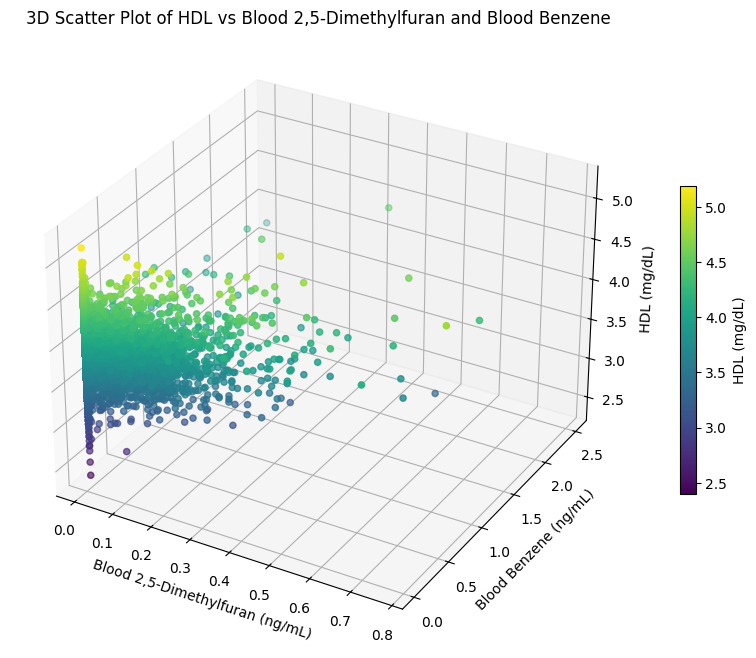

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Plot 3D para visualizar a interação
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
sc = ax.scatter(df_exe['LBX2DF'], df_exe['LBXVBZ'], df_exe['LBDHDD'], c=df_exe['LBDHDD'], cmap='viridis', marker='o')

ax.set_xlabel('Blood 2,5-Dimethylfuran (ng/mL)')
ax.set_ylabel('Blood Benzene (ng/mL)')
ax.set_zlabel('HDL (mg/dL)')
ax.set_title('3D Scatter Plot of HDL vs Blood 2,5-Dimethylfuran and Blood Benzene')

# Adicionar barra de cor
cb = plt.colorbar(sc, ax=ax, shrink=0.5)
cb.set_label('HDL (mg/dL)')

plt.show()

# # Heatmap para visualizar a interação
# plt.figure(figsize=(14, 8))
# pivot_table = df_exe.pivot_table(values='LBDHDD', index='LBXVBZ', columns='LBX2DF')
# sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt=".2f")
# plt.title('Heatmap of HDL vs Blood 2,5-Dimethylfuran and Blood Benzene')
# plt.xlabel('Blood 2,5-Dimethylfuran (ng/mL)')
# plt.ylabel('Blood Benzene (ng/mL)')
# plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Adicionar termos de interação ao DataFrame
df_exe['Interaction'] = df_exe['LBX2DF'] * df_exe['LBXVBZ']

# Modelo de regressão linear múltipla com termo de interação
model = ols('LBDHDD ~ LBX2DF * LBXVBZ + RIDAGEYR + RIAGENDR + RIDRETH1 + BMXBMI', data=df_exe).fit()

# Resumo do modelo
print(model.summary())


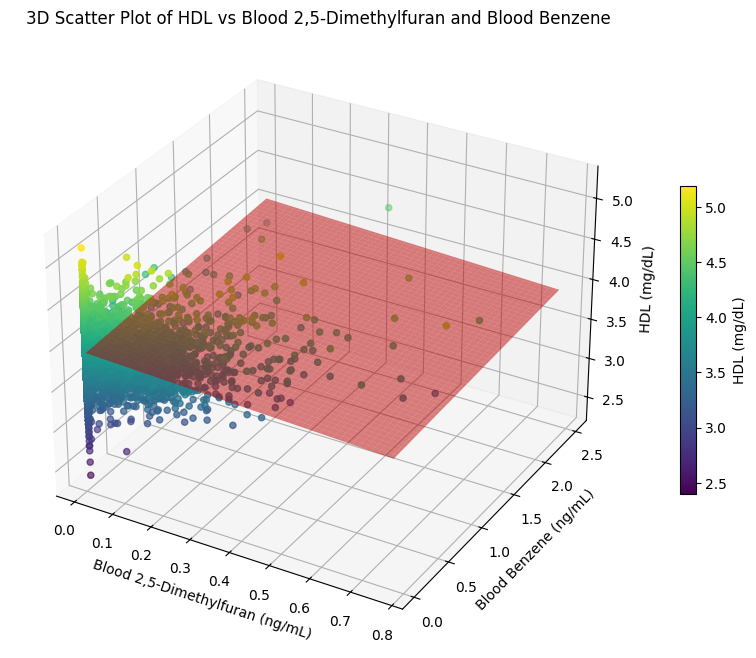

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import LinearRegression

# Supondo que df_exe seja seu DataFrame com os dados
# df_exe = pd.read_csv('path_to_your_data.csv')

# Remover linhas com valores ausentes
df_exe = df_exe.dropna(subset=['LBX2DF', 'LBXVBZ', 'LBDHDD'])


# Preparar os dados para a regressão linear
X = df_exe[['LBX2DF', 'LBXVBZ']]
y = df_exe['LBDHDD']

# Ajustar o modelo de regressão linear
reg = LinearRegression()
reg.fit(X, y)

# Prever valores de HDL ao longo de um grid de valores de LBX2DF e LBXVBZ
x_surf, y_surf = np.meshgrid(np.linspace(X['LBX2DF'].min(), X['LBX2DF'].max(), 100), np.linspace(X['LBXVBZ'].min(), X['LBXVBZ'].max(), 100))
z_surf = reg.predict(np.c_[x_surf.ravel(), y_surf.ravel()]).reshape(x_surf.shape)

# Plot 3D para visualizar a interação
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
sc = ax.scatter(df_exe['LBX2DF'], df_exe['LBXVBZ'], df_exe['LBDHDD'], c=df_exe['LBDHDD'], cmap='viridis', marker='o')

# Adicionar a superfície de tendência
ax.plot_surface(x_surf, y_surf, z_surf, color='red', alpha=0.5)

ax.set_xlabel('Blood 2,5-Dimethylfuran (ng/mL)')
ax.set_ylabel('Blood Benzene (ng/mL)')
ax.set_zlabel('HDL (mg/dL)')
ax.set_title('3D Scatter Plot of HDL vs Blood 2,5-Dimethylfuran and Blood Benzene')

# Adicionar barra de cor
cb = plt.colorbar(sc, ax=ax, shrink=0.5)
cb.set_label('HDL (mg/dL)')

plt.show()
